# **Predicting the perception of deprivation from VHR Satelite Images.**

## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py

In [2]:
from IPython.display import clear_output

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import backend as K

Check the version of Tensorflow. It should be 2.8.0

In [5]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [6]:
! nvidia-smi

Tue May 10 11:34:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 22%   34C    P0    53W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 11%   

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [7]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [8]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


Import custom functions

In [9]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [10]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file

Test is GPU(s) is(are) available for processing and measure the speed-up of using it(them). 

In [11]:
%run ../SRC/Check_GPU_available.py

2 Physical GPUs, 2 Logical GPUs
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.9804960275068879
GPU (s):
0.030682439915835857
GPU speedup over CPU: 31x


# 1. Data preparation 

**In this part, we load the data prepared before.**

In [12]:
# Set ID of experiment
experiment_id = 17   # Experiment with the best results

In [13]:
# Define working path 
root = "/home/tgrippa/PARTIMAP_processing"
data_path = os.path.join(root, "data_p3_outliers_kfold10")
output_path = os.path.join(root, "output_DenseNet_exp_%s" %experiment_id)
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [14]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17' already exists
The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/model' already exists
The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results' already exists
The folder '/home/tgrippa/PARTIMAP_processing/data_p3_outliers_kfold10' already exists


In [15]:
# Read the dataset from HDF5 file
with h5py.File(os.path.join(data_path,"RGB_224.hdf5"), mode="r") as f:
    stack = np.asarray(f["stack"])
    scores = np.asarray(f["scores"])
    photo_id = np.asarray(f["photo_id"])

In [16]:
stack.shape

(1998, 224, 224, 3)

In [17]:
photo_id.shape

(1998, 1)

In [18]:
# Read the ID of the kfold partition from CSV file
path_csv_kfold_split = "/home/tgrippa/PARTIMAP_processing/data_p3_outliers_kfold10/Partimap_10Fold_Split.csv"
a = pd.read_csv(path_csv_kfold_split)
partimap_ID_val_kfold = {x:y[1:-1].split(', ') for x,y in zip(list(a["kfold"]),a["Partimap_ID_val"])}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


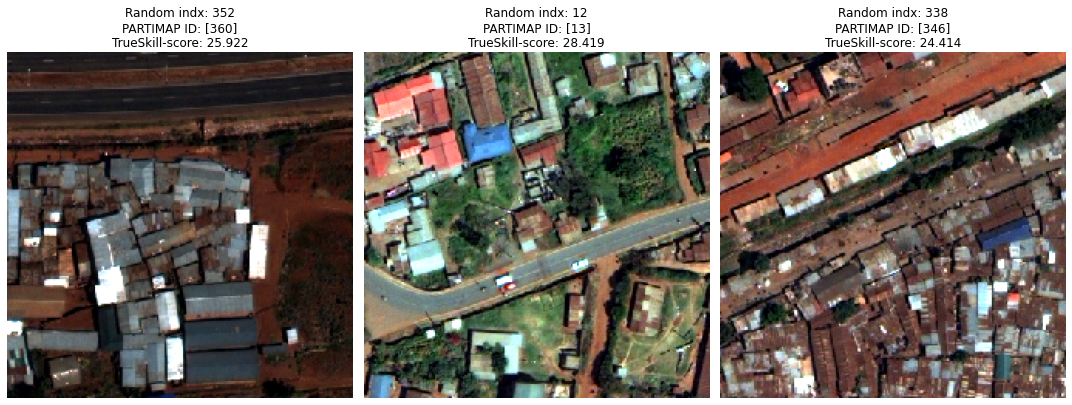

In [19]:
# Random selection
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(15, 15))
for i in range(3):
    rd_img = np.random.randint(1,500)
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Norma_Xpercentile(stack[rd_img,:,:,:]))
    plt.axis("off")
    plt.title("Random indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd_img,photo_id[rd_img],scores[rd_img]))
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

# 2 Model definition


### 2.2 Models Architecture Definition

**DenseNet121**

In [20]:
## DenseNet121 model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [21]:
def DenseNet121_model(inputshape=(224,224,3)):    
    # Create the base pre-trained model without the classification head
    base_model = DenseNet121(input_shape=inputshape, weights='imagenet', include_top=False)  
    inputs = keras.Input(shape=inputshape)
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # add dropout as regulariser to avoid overfit
    #x = Dropout(0.5)(x)
    # and a linear activation layer with 1 neuron for the regression
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    return base_model, model

# 3 Get predictions on the full dataset

## 3.1 Inference on the full dataset using the best model of the k-fold partition 

In [22]:
# Best run weights
best_weight = os.path.join(output_path, "results_mutlirun_200epochs_128bsize_Early50", "kf_7_train_0.91_val_0.84", "Best_checkoint_kf_7_train_0.91_val_0.84.hdf5")

In [23]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# Save current time for time management
starttime = time.time()
            
with strategy.scope():
    # Create a new instance of the model
    base_model, model = DenseNet121_model(inputshape=(224,224,3))
    # Optimizer and learning rate    
    opt = Adam(learning_rate=1e-3)  #For the first part of the fine-tuning we use lr=1e-3
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 

# Load the weights from the best checkpoint
model.load_weights(best_weight)
# run the model on the full dataset
pred = model.predict(stack) 
y_pred_all_bestfold = [x[0] for x in pred.tolist()]

# Print processing time
print("Processing time: %s seconds" %round(time.time() - starttime),1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [24]:
# print length of the list
len(y_pred_all_bestfold)

1998

In [25]:
# Compile results in a dataframe
lst = list(zip([x[0] for x in photo_id.tolist()],  # Partimap ID
                [round(x[0],2) for x in scores],   # True-Skill score
                [round(x,2) for x in y_pred_all_bestfold]))  # Bestfold model prediction over the whole dataset
df1 = pd.DataFrame(lst, columns =['Partimap_ID','TS_score','Pred_bestfold_nbr7'])
df1

,Partimap_ID,TS_score,Pred_bestfold_nbr7
0,1,27.21,26.80
1,2,25.59,25.33
2,3,26.10,26.36
3,4,26.99,27.05
4,5,25.78,26.30
...,...,...,...
1993,2044,27.01,27.19
1994,2045,26.19,26.25
1995,2046,25.20,25.39
1996,2047,27.24,27.41


## 3.2 Load all predictions on the test split of the k-fold partitions

In [26]:
# Get list of hdf5 files with predictions of each k-fold partitions
list_hdf5 = []
list_kfold_partitions = glob.glob(os.path.join(output_path, "results_mutlirun_200epochs_128bsize_Early50", "kf_*"))
[list_hdf5.append(glob.glob(os.path.join(x, "predictions_kf_*"))[0]) for x in list_kfold_partitions]

[None, None, None, None, None, None, None, None, None, None]

In [27]:
list_hdf5

['/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_2_train_0.91_val_0.80/predictions_kf_2_train_0.91_val_0.80.hdf5',
 '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_9_train_0.88_val_0.79/predictions_kf_9_train_0.88_val_0.79.hdf5',
 '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_4_train_0.91_val_0.80/predictions_kf_4_train_0.91_val_0.80.hdf5',
 '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_1_train_0.88_val_0.81/predictions_kf_1_train_0.88_val_0.81.hdf5',
 '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_10_train_0.88_val_0.77/predictions_kf_10_train_0.88_val_0.77.hdf5',
 '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_17/results_mutlirun_200epochs_128bsize_Early50/kf_8_train_0.92_val_0.79/prediction

In [28]:
# Read the predictins from HDF5 file
y_pred_all_kfolds = []
y_pred_all_kfolds_nbr = []
y_pred_all_kfolds_ID = []

for path in list_hdf5:
    fold_nbr = os.path.split(path)[-1].split('_')[2]
    with h5py.File(path, mode="r") as f:
        predictions_test = np.asarray(f["y_pred_test"])
        [y_pred_all_kfolds.append(x[0]) for x in predictions_test.tolist()]
        [y_pred_all_kfolds_nbr.append(int(fold_nbr)) for x in predictions_test.tolist()]
        [y_pred_all_kfolds_ID.append(int(x)) for x in partimap_ID_val_kfold[int(fold_nbr)]]

In [29]:
# print length of the list
print(len(y_pred_all_kfolds))
print(len(y_pred_all_kfolds_nbr))
print(len(y_pred_all_kfolds_ID))

1998
1998
1998


In [30]:
# Compile results in a dataframe
lst = list(zip([int(x) for x in y_pred_all_kfolds_ID],  # Partimap ID
                [round(x,2) for x in y_pred_all_kfolds], # Prediction of test set of all partitions
                [x for x in y_pred_all_kfolds_nbr])) # The number of the partition
df2 = pd.DataFrame(lst, columns =['Partimap_ID','Pred_all_kfolds','kfolds_nbr'])
df2 = df2.sort_values("Partimap_ID")
df2

,Partimap_ID,Pred_all_kfolds,kfolds_nbr
599,1,27.08,1
200,2,25.22,9
1798,3,26.66,3
799,4,26.69,10
1598,5,26.30,7
...,...,...,...
199,2044,26.48,2
797,2045,26.00,1
1597,2046,25.80,5
798,2047,26.81,1


## 4 Export results to CSV

In [31]:
# Join the two dataframe
df_final = df1.join(df2.set_index('Partimap_ID'),on='Partimap_ID', how='left')
df_final

,Partimap_ID,TS_score,Pred_bestfold_nbr7,Pred_all_kfolds,kfolds_nbr
0,1,27.21,26.80,27.08,1
1,2,25.59,25.33,25.22,9
2,3,26.10,26.36,26.66,3
3,4,26.99,27.05,26.69,10
4,5,25.78,26.30,26.30,7
...,...,...,...,...,...
1993,2044,27.01,27.19,26.48,2
1994,2045,26.19,26.25,26.00,1
1995,2046,25.20,25.39,25.80,5
1996,2047,27.24,27.41,26.81,1


In [32]:
df_final[df_final['Partimap_ID'].isin([5,14,28])]

,Partimap_ID,TS_score,Pred_bestfold_nbr7,Pred_all_kfolds,kfolds_nbr
4,5,25.78,26.30,26.30,7
13,14,25.41,25.88,25.88,7
27,28,27.06,25.58,25.58,7


In [35]:
# Write dataframe to a CSV
df_final.to_csv(os.path.join(output_path, "Prediction_results.csv"),index=False)